<a href="https://colab.research.google.com/github/srinithish/Deep-Learning/blob/master/HW4_Prob2_Final_Srinithish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import sklearn
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import matplotlib.cm as cm
import math
import pickle

In [0]:
with open('hw4_tr7.pkl', 'rb') as f:
  
  InpImages = pickle.load(f)

#### Using a latent vector of 3 dimensions

In [0]:
##network params
learning_rate = tf.constant(0.0001)



#list of nodes  excpet x and y

(numExamples,imgHeight,imgWidth) = InpImages.shape

X = tf.placeholder(tf.float32,[None,imgHeight,imgWidth],name = "X")
Y  =  tf.placeholder(tf.float32,[None,imgHeight,imgWidth], name = "Y")
keepProb = tf.placeholder(tf.float32)

LatentVectorDim = 3

In [0]:
InpImages.shape

(6265, 28, 28)

 ## Encode with 
 1. Conv2d 4*4 filter 16 of them
 2. Maxpool with 4*4 with stride 4
 3. Conv2d 2*2 Filter 32 of them
 4. Maxpool with 4*4 with stride 4
 5. Dense  of 784 units
 6. Dense for mu with 3 units and Dense for LogSigmaSquare with 3 units (No activation)

In [0]:
def encoder(xInp):
  xInp = tf.reshape(xInp, shape=[-1, 28, 28, 1])
  
#   initialiser = tf.contrib.layers.variance_scaling_initializer()
  initialiser  = tf.contrib.layers.xavier_initializer()
  
  conv1 = tf.layers.conv2d(
      inputs=xInp,
      filters=16,
      kernel_size=[4, 4],
      padding="same",
      activation=tf.nn.relu,kernel_initializer=initialiser)

  maxpool1= tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 4], strides=4)

  conv2 = tf.layers.conv2d(
      inputs=maxpool1,
      filters=32,
      kernel_size=[2,2],
      padding="same",
      activation=tf.nn.relu,kernel_initializer=initialiser)
  
  maxpool2= tf.layers.max_pooling2d(inputs=conv2, pool_size=[4, 4], strides=4)
  
  flattenlayer = tf.layers.flatten(maxpool2)

  dense1= tf.layers.dense(
      inputs=flattenlayer,
      units=784,
      activation=tf.nn.relu,
      kernel_initializer=initialiser
  )
  
  mu = tf.layers.dense(
      inputs=dense1,
      units=LatentVectorDim,kernel_initializer=initialiser
  )
  
  log_sigma_square = tf.layers.dense(
                     inputs=dense1,
                       units=LatentVectorDim,kernel_initializer=initialiser
                      )
  
#   output =tf.layers.dense(
#       inputs=dense1,
#       units=LatentVectorDim*2
#   )
  
  
#   mu = output[:,:LatentVectorDim]
#   log_sigma_square  = output[:,LatentVectorDim:]
  
  return mu,log_sigma_square

## Dedcoder
1. Dense with 112*112 dimensions
2. Conv2d with 4*4 , 32 of them 
3. Maxpool with 2 * 2 and stride 2
4. Conv2d with 2 * 2 , and 1 filter

This configuration generates a 28 * 28 map which can be used as image

In [0]:
def decoder(LatentVector):
  
#   initialiser = tf.contrib.layers.variance_scaling_initializer()
  initialiser   = tf.contrib.layers.xavier_initializer()
#   dense1 = tf.layers.dense(inputs=LatentVector,
#   units=100,
#   activation=tf.nn.relu
#   )

  dense2 =tf.layers.dense( inputs=LatentVector,
                          units=112*112,
                          activation=tf.nn.relu,
                          kernel_initializer=initialiser
                          )


  reshapedFullyConnectedOutput = tf.reshape(dense2, [-1,112 ,112 ,1])


  conv1 = tf.layers.conv2d(
      inputs=reshapedFullyConnectedOutput,
      filters=32,
      kernel_size=[4, 4],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=initialiser
  )

  maxpool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  conv2 = tf.layers.conv2d(
      inputs=maxpool1,
      filters=1,
      kernel_size=[2,2],
      padding="same",
      kernel_initializer=initialiser,
      activation=None)

  maxpool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  
  
  return maxpool2

In [0]:
## accuracy metirc 
def RSquared(yAct, yPred):

    residual = tf.reduce_sum(tf.square(tf.subtract(yAct, yPred)))
    total = tf.reduce_sum(tf.square(tf.subtract(yAct, tf.reduce_mean(yAct))))
    r2 = tf.subtract(1.0, tf.math.divide(residual, total))
    return r2
  
  

## Losses
1. Reconstruction loss as cross entropy since all the values are in 0 to 1 

2. latent loss is the KL Divergence

I have referred the book Hands-On Machine Learning with Scikit-Learn & TensorFlow chapter VAE for loss functions

https://cloud.moezx.cc/Document/Hands-On%20Machine%20Learning%20with%20Scikit-Learn%20and%20TensorFlow.pdf

In [0]:

mean, log_sigma_square = encoder(X)

sigma = tf.exp(0.5 * log_sigma_square)

epsilon = tf.random_normal(tf.shape(sigma), dtype=tf.float32)


LatentVector =  mean + sigma * epsilon

logits = decoder(LatentVector)

FinalOutput = tf.sigmoid(logits)

reshapedFinalOutput = tf.reshape(FinalOutput, [-1, 28,28]) ###removing depth


logits = tf.reshape(logits, [-1, 28,28]) ###removing depth


##lossses
# imageLoss  = tf.losses.mean_squared_error(labels = Y ,predictions = reshapedFinalOutput)

imageLoss_msq  = tf.reduce_mean(tf.square(reshapedFinalOutput-X))

imageLoss_cross = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))


latentLoss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_square) + tf.square(mean) - 1 - log_sigma_square)



totalLoss = imageLoss_cross + latentLoss



AdamOptimizer = tf.train.AdamOptimizer(learning_rate=0.0003)

train = AdamOptimizer.minimize(totalLoss)

accuracy = RSquared(reshapedFinalOutput,Y)

initialise = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [0]:
np.shape(reshapedFinalOutput)

TensorShape([Dimension(None), Dimension(28), Dimension(28)])

## Training 

In [0]:
### training and running the sessions

currSess = tf.InteractiveSession()

batchSize = 40

x_train = InpImages

y_train = InpImages

##training 
currSess.run(initialise)
# x = currSess.run(KLDivergence,feed_dict ={X:X_train[:2],Y:y_train[:2],keepProb: 0.9})

for epoch in range(600):
  loss = 0
  accu = 0
  for index, offset in enumerate(range(0, len(x_train), batchSize)):

    xBatch, yBatch = x_train[offset: offset + batchSize], y_train[offset: offset + batchSize]
    

    ## drop out train time keep Prob = 0.9
    currSess.run(train,feed_dict ={X:xBatch,Y:yBatch,keepProb: 1})

    loss += currSess.run(totalLoss, feed_dict={X: xBatch, Y: yBatch,keepProb: 1})
  ## drop out test time keep prob = 1
    
#   accu = currSess.run([accuracy], feed_dict={X: x_train, Y: y_train,keepProb: 1})  
#       accu = 0
  print(currSess.run(latentLoss,feed_dict ={X:xBatch,Y:yBatch,keepProb: 1}))
  print("Step " + str(epoch) + ", Loss= " + str(loss))
     


474.24716
Step 0, Loss= 2488451.3857421875
193.7752
Step 1, Loss= 1357333.2900390625
136.58438
Step 2, Loss= 1263943.19921875
104.702934
Step 3, Loss= 1228119.318359375
140.14081
Step 4, Loss= 1171717.2631835938
160.49263
Step 5, Loss= 1050264.7238769531
158.42102
Step 6, Loss= 1004117.5341796875
151.25966
Step 7, Loss= 985121.1669921875
151.61281
Step 8, Loss= 970921.4594726562
151.75798
Step 9, Loss= 959388.8916015625
149.01216
Step 10, Loss= 948989.9028320312
153.07242
Step 11, Loss= 939458.3151855469
151.2068
Step 12, Loss= 931156.796875
151.00037
Step 13, Loss= 925483.1762695312
148.38208
Step 14, Loss= 919891.5891113281
149.95798
Step 15, Loss= 913627.4221191406
147.83934
Step 16, Loss= 908828.4995117188
149.67918
Step 17, Loss= 905121.2612304688
151.87491
Step 18, Loss= 900593.4033203125
153.03201
Step 19, Loss= 895971.3996582031
154.21445
Step 20, Loss= 892061.2412109375
152.547
Step 21, Loss= 888157.2583007812
156.25354
Step 22, Loss= 884090.1064453125
155.86755
Step 23, Loss=

In [0]:
LatentVectorEval = currSess.run(LatentVector,feed_dict ={X:x_train,Y:x_train,keepProb: 1})

In [0]:
minLatent = np.min(LatentVectorEval,axis = 0)
maxLatent = np.max(LatentVectorEval,axis = 0)
meanLatent = np.mean(LatentVectorEval,axis = 0)





### Keeping 2 dimensions constant and changing one of them

#### taking the ranges of min and mean values on latent vectors and generating codings

In [0]:
codings = np.repeat([[meanLatent[0], meanLatent[1], meanLatent[2]]],[50], axis = 0)
changingColumnAt0 =  np.linspace(minLatent[0],maxLatent[0])
changingColumnAt1 =  np.linspace(minLatent[1],maxLatent[1])
changingColumnAt2 =  np.linspace(minLatent[2],maxLatent[2])

firstChangeArray = codings.copy()
firstChangeArray[:,0] = changingColumnAt0

secondChangeArray = codings.copy()
secondChangeArray[:,1] = changingColumnAt1

thirdChangeArray = codings.copy()
thirdChangeArray[:,2] = changingColumnAt2


In [0]:


Prediction1Images = reshapedFinalOutput.eval(feed_dict={LatentVector: firstChangeArray})
Prediction2Images = reshapedFinalOutput.eval(feed_dict={LatentVector: secondChangeArray})
Prediction3Images = reshapedFinalOutput.eval(feed_dict={LatentVector: thirdChangeArray})

In [0]:
def plotImages(PredictionImages,gridSize):
  fig, axes = plt.subplots(gridSize, gridSize)
  
  for i in range(gridSize):
     
    for j in range(gridSize):
      
        axes[i, j].imshow(PredictionImages[i*gridSize+j])
        axes[i,j].axis('off')
      
      


### Varying the 1st  dimension the 7 tilts from being clockwise 7 to anticlockwise 7

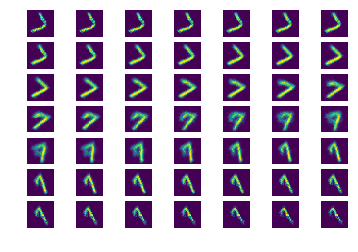

In [0]:
plotImages(Prediction1Images,7)

### This dimensions captures the regular straight 7s

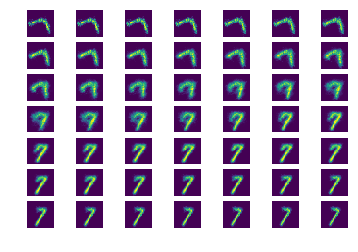

In [0]:
plotImages(Prediction3Images,7)

### This dimension captures a few of clockwise rotations, dashed 7s and regular 7s

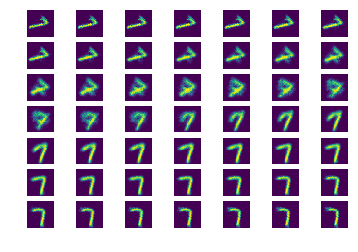

In [0]:
plotImages(Prediction2Images,7)

## Test Images reconstructed

In [0]:
with open('hw4_te7.pkl', 'rb') as f:
  
  TestImages = pickle.load(f)
  
testReconstructedImage = currSess.run(reshapedFinalOutput,feed_dict ={X:TestImages,Y:TestImages,keepProb: 1})

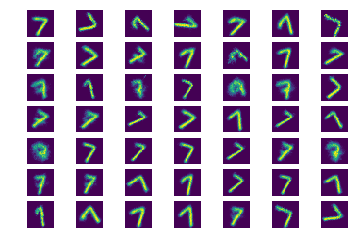

In [0]:
plotImages(testReconstructedImage,7)